# **Task 3**

In [31]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import datetime

In [32]:
# Importing Traffic dataset
df=pd.read_csv('traffic.csv')

In [33]:
df.head()

,event,date,country,city,artist,album,track,isrc,linkid
0,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
1,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
2,click,2021-08-21,India,Ludhiana,Reyanna Maria,So Pretty,So Pretty,USUM72100871,23199824-9cf5-4b98-942a-34965c3b0cc2
3,click,2021-08-21,France,Unknown,"Simone & Simaria, Sebastian Yatra",No Llores Más,No Llores Más,BRUM72003904,35573248-4e49-47c7-af80-08a960fa74cd
4,click,2021-08-21,Maldives,Malé,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8


In [34]:
# Details of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226278 entries, 0 to 226277
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   event    226278 non-null  object
 1   date     226278 non-null  object
 2   country  226267 non-null  object
 3   city     226267 non-null  object
 4   artist   226241 non-null  object
 5   album    226273 non-null  object
 6   track    226273 non-null  object
 7   isrc     219157 non-null  object
 8   linkid   226278 non-null  object
dtypes: object(9)
memory usage: 15.5+ MB


In [35]:
# Summary of the data
df.describe(include='all')

,event,date,country,city,artist,album,track,isrc,linkid
count,226278,226278,226267,226267,226241,226273,226273,219157,226278
unique,3,7,211,11993,2419,3254,3562,709,3839
top,pageview,2021-08-19,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
freq,142015,35361,47334,22791,40841,40841,40841,40841,40841


In [36]:
# Ckeck for missing values
df.isnull().sum()

,0
event,0
date,0
country,11
city,11
artist,37
album,5
track,5
isrc,7121
linkid,0


In [37]:
# Handling missing values
df['country']=df['country'].fillna('unknown')
df['city']=df['city'].fillna('unknown')
df['artist']=df['artist'].fillna('N/A')
df['album'] = df['album'].fillna('General Navigation')
df['track']=df['track'].fillna('N/A')
df['isrc']=df['isrc'].fillna('N/A')

In [38]:
df.isnull().sum()

,0
event,0
date,0
country,0
city,0
artist,0
album,0
track,0
isrc,0
linkid,0


**Check for duplicate records**

In [39]:
df.duplicated().sum()

np.int64(103711)

The dataset has 226278 records out of which 103711 records are duplicate. Means that only 54% of the data is actual data.

**In web traffic logs, exact duplicatesusually happen because of:**

- Double-tagging: The tracking script on the website is firing twice for a single action.

- Page Refreshes: A user hits "refresh," causing the same event to log again.

- Server Glitches: The log-collection server received the same data packet twice.

We must remove them.

In [40]:
# Remove exact duplicates
df=df.drop_duplicates()

# Reset index for a clean dataframe
df=df.reset_index(drop=True)

Making time usable and removing the useless rows.

In [41]:
# Converting date column from object to datetime format
df['date'] = pd.to_datetime(df['date'])

In [42]:
df['time_diff'] = df.groupby('linkid')['date'].diff().dt.seconds
df['new_session'] = (df['time_diff'] > 1800) | (df['time_diff'].isna())
df['session_id'] = df.groupby('linkid')['new_session'].cumsum()


**Users & Sessions**

In [44]:
users = df['linkid'].nunique()
sessions = df[['linkid','session_id']].drop_duplicates().shape[0]
print('Users :', users)
print('Sessions:' ,sessions)


Users : 3839
Sessions: 3839


**Average Session Duration**

In [45]:
session_duration = df.groupby(['linkid', 'session_id'])['date'].apply(lambda x: (x.max() - x.min()).total_seconds())
average_session_duration = session_duration.mean()
print(f"Average session duration: {average_session_duration:.2f} seconds")

Average session duration: 71681.17 seconds


**Bounce Rate**

In [46]:
events_per_session = df.groupby(['linkid','session_id'])['event'].count().mean()
bounce_rate = (events_per_session == 1).mean() * 100
print('bounce_rate:',bounce_rate)
print('events_per_session',events_per_session)

bounce_rate: 0.0
events_per_session 31.92680385517062


**Entry & Exit Events**

In [48]:
entry_events = df.groupby(['linkid','session_id']).first()['event'].value_counts().mean()
exit_events = df.groupby(['linkid','session_id']).last()['event'].value_counts().mean()
print('entry_events',entry_events)
print('exit_events',exit_events)

entry_events 1279.6666666666667
exit_events 1919.5


In [49]:
# To see WHICH events are the top entry points
entry_distribution = df.groupby(['linkid','session_id']).first()['event'].value_counts()

# To see it as percentages (e.g., "80% of people start with a pageview")
entry_percentages = df.groupby(['linkid','session_id']).first()['event'].value_counts(normalize=True) * 100

print(entry_distribution)
print(entry_percentages)

event
click       2255
pageview    1553
preview       31
Name: count, dtype: int64
event
click       58.739255
pageview    40.453243
preview      0.807502
Name: proportion, dtype: float64


Traffic Breakdown (Geography & Content)

In [50]:
top_countries = df['country'].value_counts()
top_cities = df['city'].value_counts()
top_artists = df['artist'].value_counts()
top_tracks = df['track'].value_counts()

print('Top Countries:')
print(top_countries.head())
print('\nTop Cities:')
print(top_cities.head())
print('\nTop Artists:')
print(top_artists.head())
print('\nTop Tracks:')
print(top_tracks.head())

Top Countries:
country
United States     28664
India             18689
France            10565
Saudi Arabia       7682
United Kingdom     5095
Name: count, dtype: int64

Top Cities:
city
Unknown      8797
Jeddah       2497
Riyadh       2232
Hyderabad    1088
Dammam       1002
Name: count, dtype: int64

Top Artists:
artist
Tesher            8288
Anne-Marie        4029
Tundra Beats      3951
Roddy Ricch       3107
Olivia Rodrigo    3037
Name: count, dtype: int64

Top Tracks:
track
Jalebi Baby                             8288
Beautiful                               4037
Beautiful Day                           3951
Late At Night                           3059
ily (i love you baby) (feat. Emilee)    2956
Name: count, dtype: int64


Visualization

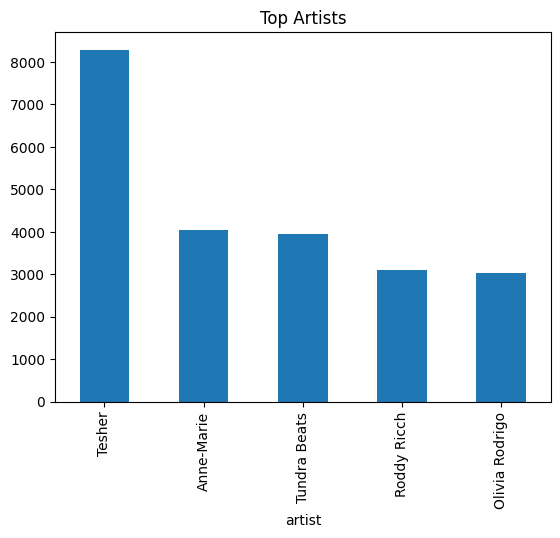

In [51]:
import matplotlib.pyplot as plt

top_artists = df['artist'].value_counts()
top_artists.head(5).plot(kind='bar', title='Top Artists')
plt.show()

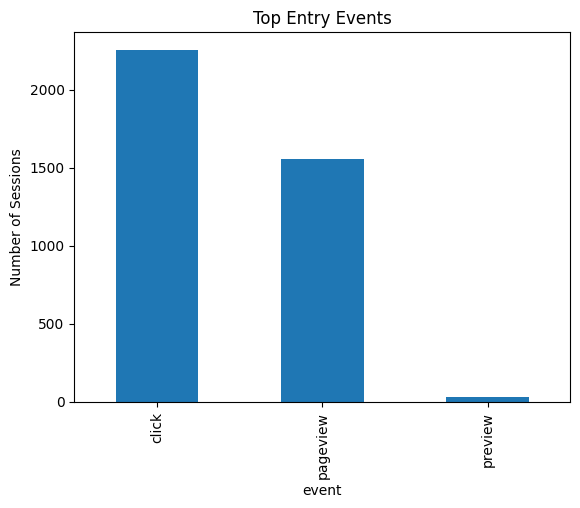

In [55]:
entry_events = df.groupby(['linkid', 'session_id']).first()['event'].value_counts()

entry_events.head(5).plot(kind='bar', title='Top Entry Events')
plt.ylabel('Number of Sessions')
plt.show()

In [57]:
user_journeys = df.groupby(['linkid','session_id'])['event'].apply(list)
user_journeys

,,event
linkid,session_id,
00073307-ae96-5089-a117-4783afb42f8e,1,"[pageview, pageview]"
00126b32-0c35-507b-981c-02c80d2aa8e7,1,"[click, click, pageview, pageview]"
0018cfff-50a1-5984-9715-01ef2d11a49a,1,[pageview]
0033934b-5d16-5a06-af58-d087bcdd3680,1,[pageview]
0034d6cf-3bd8-5ffe-aafc-b3959fc48608,1,[pageview]
...,...,...
fff38ca0-8043-50cd-a5f1-f65ebb7105c5,1,"[click, pageview]"
fff4e5f0-4ee5-5fe7-aa30-e870edaf6ed7,1,[pageview]
fff84c0e-90a1-59d8-9997-adc909d50e16,1,"[click, pageview]"


In [58]:
# Convert the list to a string so we can count them
common_paths = user_journeys.apply(lambda x: ' -> '.join(x)).value_counts()

print("Top 5 User Journeys:")
print(common_paths.head(5))

Top 5 User Journeys:
event
pageview                                  1363
click -> pageview                         1208
click -> pageview -> pageview              224
pageview -> pageview                       143
click -> click -> pageview -> pageview      81
Name: count, dtype: int64
